#### https://keras.io/examples/vision/mixup/

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

2023-08-22 05:26:41.315860: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

2023-08-22 05:26:44.000735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38319 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

In [4]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [5]:

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


2023-08-22 05:37:49.073817: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype float and shape [58000,10]
	 [[{{node Placeholder/_12}}]]
2023-08-22 05:37:49.074209: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [58000,28,28,1]
	 [[{{node Placeholder/_11}}]]


[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.4862573444843292, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5137426853179932]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.04906576871871948, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9509342312812805]
[0.0, 0.0, 0.3829231560230255, 0.0, 0.0, 0.0, 0.6170768737792969, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.644960359209918e-11]
[0.0, 0.21782980859279633, 0.0, 0.0, 0.0, 0.0, 0.7821701765060425, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.9983343482017517, 0.001665651798248291, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


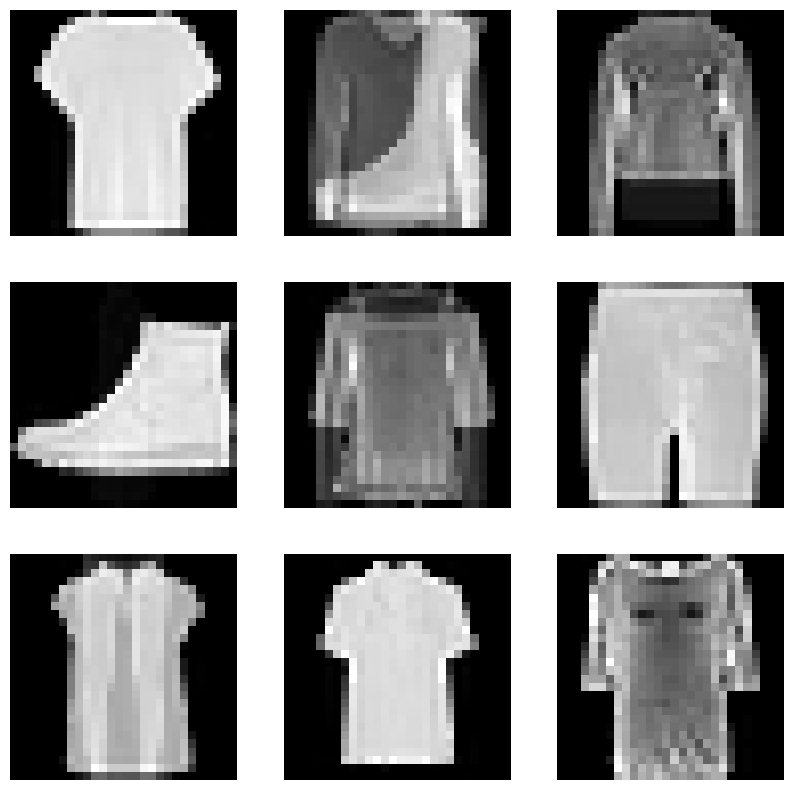

In [10]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    print(label.numpy().tolist())
    plt.axis("off")

In [7]:

def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model


In [8]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

In [9]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10


2023-08-22 05:24:23.287256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-22 05:24:23.429716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2023-08-22 05:24:23.636986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-22 05:24:23.670326: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55ffd6ad7430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-22 05:24:23.670372: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-08-22 05:24:23.675660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_

907/907 [==============================] - ETA: 0s - loss: 1.1885 - accuracy: 0.6261

2023-08-22 05:24:27.194879: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2000,10]
	 [[{{node Placeholder/_1}}]]


907/907 [==============================] - 5s 3ms/step - loss: 1.1885 - accuracy: 0.6261 - val_loss: 0.6867 - val_accuracy: 0.7505
Epoch 2/10
907/907 [==============================] - 2s 3ms/step - loss: 0.9497 - accuracy: 0.7219 - val_loss: 0.5626 - val_accuracy: 0.8000
Epoch 3/10
907/907 [==============================] - 2s 3ms/step - loss: 0.8643 - accuracy: 0.7652 - val_loss: 0.4863 - val_accuracy: 0.8305
Epoch 4/10
907/907 [==============================] - 2s 3ms/step - loss: 0.8090 - accuracy: 0.7873 - val_loss: 0.4466 - val_accuracy: 0.8470
Epoch 5/10
907/907 [==============================] - 2s 2ms/step - loss: 0.7681 - accuracy: 0.8015 - val_loss: 0.4209 - val_accuracy: 0.8515
Epoch 6/10
907/907 [==============================] - 2s 3ms/step - loss: 0.7428 - accuracy: 0.8084 - val_loss: 0.4088 - val_accuracy: 0.8550
Epoch 7/10
907/907 [==============================] - 2s 3ms/step - loss: 0.7278 - accuracy: 0.8121 - val_loss: 0.3919 - val_accuracy: 0.8575
Epoch 8/10
907/90

2023-08-22 05:24:48.882099: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


157/157 [==============================] - 0s 1ms/step - loss: 0.3882 - accuracy: 0.8646
Test accuracy: 86.46%


In [9]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10


2023-08-22 05:27:15.386635: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [58000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-08-22 05:27:15.386943: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [58000,10]
	 [[{{node Placeholder/_1}}]]
2023-08-22 05:27:16.043628: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-22 05:27:16.155834: I 

907/907 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.6745

2023-08-22 05:27:19.672497: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2000,10]
	 [[{{node Placeholder/_1}}]]


907/907 [==============================] - 4s 3ms/step - loss: 0.8767 - accuracy: 0.6745 - val_loss: 0.6332 - val_accuracy: 0.7675
Epoch 2/10
907/907 [==============================] - 2s 2ms/step - loss: 0.6116 - accuracy: 0.7688 - val_loss: 0.5261 - val_accuracy: 0.8115
Epoch 3/10
907/907 [==============================] - 2s 2ms/step - loss: 0.5219 - accuracy: 0.8097 - val_loss: 0.4571 - val_accuracy: 0.8375
Epoch 4/10
907/907 [==============================] - 2s 2ms/step - loss: 0.4666 - accuracy: 0.8298 - val_loss: 0.4237 - val_accuracy: 0.8455
Epoch 5/10
907/907 [==============================] - 2s 3ms/step - loss: 0.4328 - accuracy: 0.8446 - val_loss: 0.3809 - val_accuracy: 0.8690
Epoch 6/10
907/907 [==============================] - 2s 2ms/step - loss: 0.4037 - accuracy: 0.8528 - val_loss: 0.3676 - val_accuracy: 0.8635
Epoch 7/10
907/907 [==============================] - 2s 2ms/step - loss: 0.3825 - accuracy: 0.8615 - val_loss: 0.3470 - val_accuracy: 0.8780
Epoch 8/10
907/90

2023-08-22 05:27:40.052966: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


157/157 [==============================] - 0s 1ms/step - loss: 0.3409 - accuracy: 0.8770
Test accuracy: 87.70%
